In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
# plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from math import floor
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
import interpret

# prepare data

In [2]:
# currently trained only on 'clath_aux+gak_a7d2_new'
dsets = ['clath_aux+gak_new']
splits = ['test']
#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs = {}
for dset in tqdm(dsets):
    for split in splits:
        df = data.get_data(dset=dset)
        df = df[~(df.short | df.long | df.hotspots)]
#         df = df[df.valid]
        df = df[df.lifetime > 15] # only keep hard tracks
        df = df[df.cell_num.isin(config.DSETS[dset][split])] # exclude held-out test data
        feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))

        # downsample tracks
        length = 40
        df['X_same_length'] = [features.downsample(df.iloc[i]['X'], length)
                               for i in range(len(df))] # downsampling
        # normalize tracks
        df = features.normalize_track(df, track='X_same_length', by_time_point=False)

        # regression response
        df = train_reg.add_sig_mean(df)     

        # remove extraneous feats
        # df = df[feat_names + meta]
#         df = df.dropna() 

        # normalize features
        for feat in feat_names:
            if 'X_same_length' not in feat:
                df = features.normalize_feature(df, feat)

        dfs[(dset, split)] = deepcopy(df)

# load model
p = 1
results = pkl.load(open('../models/dnn_full_long_normalized_across_track_1_feat.pkl', 'rb'))
dnn = neural_networks.neural_net_sklearn(D_in=40, H=20, p=p-1, arch='lstm')

# load data
# df = dfs[('clath_aux+gak_a7d2', 'train')]
df = dfs[('clath_aux+gak_new', 'test')]
X = df[feat_names[:p]]
y = df['y_consec_thresh']

100%|██████████| 1/1 [00:00<00:00,  1.03it/s]


# segmentation

In [64]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
df = dfs[('clath_aux+gak_new', 'test')]
x = df[feat_names[:1]]
y = df['y_consec_thresh']
m = 40
xtrack_unnormalized = df[track_name_unnormalized]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)
preds = dnn.predict(x)
print('acc', np.mean((preds > 0) == y))

acc 0.6682464454976303


In [54]:
# calculate all cd scores
cd_score_path = f'../data/outputs/all_cd_scores_clath_aux+gak_new_test.pkl'
if os.path.exists(cd_score_path):
    all_cd_scores = pd.read_pickle(cd_score_path)
else:
    all_cd_scores = {}
    for s in tqdm(range(m)):
        for e in range(s+1, m+1):
            all_cd_scores[(s, e)] = interpret.calc_cd_score(xtrack_t, xfeats_t, s, e, dnn.model)
    with open(cd_score_path, 'wb') as handle:
        pkl.dump(all_cd_scores, handle, protocol=pkl.HIGHEST_PROTOCOL)

In [55]:
# find best segmentations
all_res = []
for i in range(len(x)):
    cd_scores_list = np.zeros((m, m))
    for s in (range(m)):
        for e in range(s + 1, m + 1):            
            cd_scores_list[s][e-1] = all_cd_scores[(s, e)][i]
    res, paths = interpret.max_abs_sum_seg(cd_scores_list, min_length=5)
    lt = np.sum(np.array(df[track_name_unnormalized].values[i]) != 0)
    #all_res.append(paths[lt-1])
    all_res.append(paths[m - 1])
    #print(res[lt-1], paths[lt-1])
def extract_segs_and_scores(all_res, i):
    segs = [(all_res[i][j], all_res[i][j+1])
            for j in range(len(all_res[i])-1)] + [(all_res[i][-1], 40)]
    scores = [all_cd_scores[(s, e)][i][0]
              for (s, e) in segs]
    return segs, scores

In [58]:
idxs = np.argsort(preds)
preds = preds[idxs]
y = y.values[idxs]
all_res = np.array(all_res, dtype='object')[idxs]
n = all_res.size

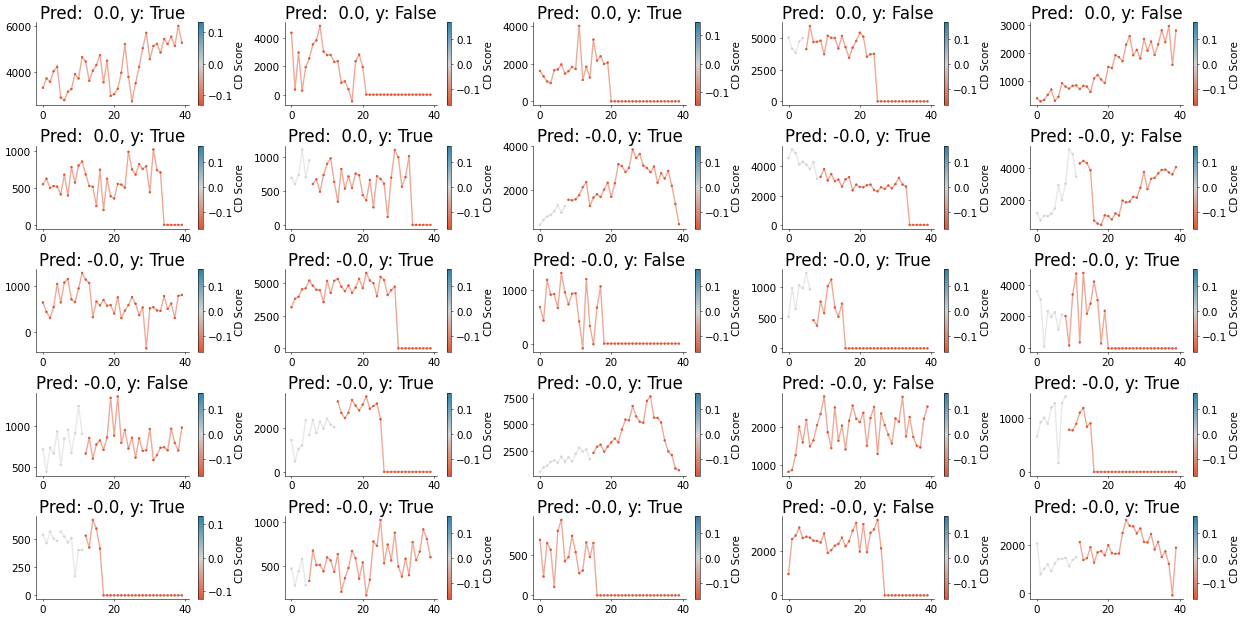

In [60]:
which_tracks = 'pos' # random, neg, pos
C, R = 5, 5
plt.figure(dpi=50, figsize=(5 * C, 2.5 * R))
for i in range(0, 25):
    ax = plt.subplot(R, C, i + 1)
    if which_tracks == 'random':
        arg = np.random.permutation(np.arange(n))
    elif which_tracks == 'neg':
        arg = np.arange(n)
    elif which_tracks == 'pos':
        arg = np.arange(n)[::-1]
    segs, scores = extract_segs_and_scores(all_res[arg], n - 1 - i)
    interpret.plot_segs(track_segs=segs, cd_scores=scores, xtrack=xtrack_unnormalized.iloc[i],
              pred=preds[arg][i],
              y=y[arg][i])
plt.tight_layout()
plt.show()

**make simple illustrative plot**

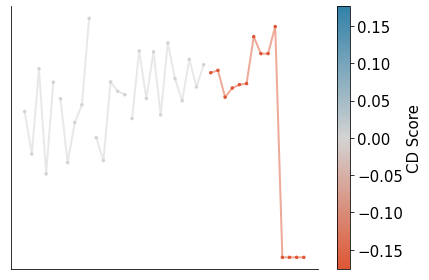

In [31]:
i = 101
segs, scores = extract_segs_and_scores(all_res, i)
interpret.plot_segs(track_segs=segs, cd_scores=scores, xtrack=xtrack_unnormalized.iloc[i])
plt.yticks([])
plt.xticks([])
plt.show()
#               pred=dnn.predict(x)[i],
#               y=y.values[i])

**recalculate with normalized scores (there is some err here)**

In [ ]:
all_cd_scores_normalized = {}
for s in tqdm(range(m)):
    for e in range(s + 1, m + 1):
        x = all_cd_scores[(s, e)]
        x = x.reshape(1, -1)[0]
        all_cd_scores_normalized[(s, e)] = np.abs((x - np.mean(x)) / np.std(x))
        
for i in range(len(df)):
    cd_scores_list = np.zeros((m, m))
    s0, e0 = 0, 0
    m = 0
    lt = np.sum(np.array(df[track_name_unnormalized].values[i]) != 0)
    for s in (range(lt)):
        for e in range(s+1, lt):            
            cd_scores_list[s][e-1] = all_cd_scores_normalized[(s, e)][i]
            if cd_scores_list[s][e-1] > m:
                m = cd_scores_list[s][e-1]
                s0, e0 = s, e

In [244]:
with open(f'results/all_cd_scores_clath_aux+gak_new_test.pkl', 'wb') as handle:
    pkl.dump(all_cd_scores, handle, protocol=pkl.HIGHEST_PROTOCOL)

# interpret one pred at multiple scales

In [5]:
def plot_segs(track_segs, cd_scores, xtrack, pred):
    cm = sns.diverging_palette(22, 220, as_cmap=True, center='light')
    vabs = np.max(np.abs(cd_scores))
    # plt.plot(xtrack, zorder=0, lw=2, color='#111111')
    for i in range(len(track_segs)):
        (s, e) = track_segs[i]
        cd_score = cd_scores[i]
        seq_len = e - s
        xs = np.arange(s, e)
        norm = matplotlib.colors.Normalize(vmin=-vabs, vmax=vabs)
        if seq_len > 1:
            cd_score = [cd_score] * seq_len
            plt.plot(xs, xtrack[s: e], zorder=0, lw=2, color=cm(norm(cd_score[0])), alpha=0.5)
        plt.scatter(xs, xtrack[s: e],
                    c=cd_score, cmap=cm, vmin=-vabs, vmax=vabs, s=6)

In [10]:
track_name = 'X_same_length_normalized'
track_name_unnormalized = 'X_same_length'
num = 100
x = X.iloc[num: num + 1]
xtrack_unnormalized = df.iloc[num: num + 1][track_name_unnormalized]
xtrack = x[track_name]
xtrack_t = torch.tensor(np.array(list(xtrack.values)), dtype=torch.float)
xfeats = x[[c for c in x.columns if c != track_name]]
xfeats_t = torch.tensor(np.array(xfeats).astype(float), dtype=torch.float)
pred = dnn.model(xtrack_t, xfeats_t).item()
#print(f'pred {pred:0.2f}')

In [8]:
T = 40 # seq len
# track_segs = [(s, s + 1) for s in range(T)]
DIV = 40
track_segs_fourty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]

DIV = 20
track_segs_twenty = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 10
track_segs_tenths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 6
track_segs_fifths = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 4
track_segs_quarters = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
DIV = 1
track_segs_full = [(floor(s * T / DIV), floor((s+1) * T / DIV))
                    for s in range(DIV)]
track_segs_list = [track_segs_fourty, track_segs_twenty, track_segs_tenths,
                   track_segs_fifths, track_segs_quarters, track_segs_full]
cd_scores_list = [[interpret.calc_cd_score(xtrack_t, xfeats_t, s, e, dnn.model)
                  for (s, e) in track_segs]
                  for track_segs in tqdm(track_segs_list)]


100%|██████████| 6/6 [00:07<00:00,  1.17s/it]


In [ ]:
plt.figure(dpi=200, figsize=(12, 6))
R, C = 2, 3
for i, track_segs in enumerate(track_segs_list):
    ax = plt.subplot(R, C, i + 1)
    cd_scores = cd_scores_list[i]
    interpret.plot_segs(track_segs, cd_scores, xtrack_unnormalized.iloc[0], pred, y=0)
    
    if i == C * (R - 1):
        plt.xlabel('Time')
    else:
        plt.xticks([])
    if i == 0:
        plt.ylabel('Clath Amplitude')
    else:
        plt.yticks([])
    if i  == C - 1:
        plt.colorbar(label='CD Score')
    else:
        plt.colorbar()
    if i ==  C * R - 1:
        plt.text(0.6, 0.9,
                 f'Pred: {pred:.2f}', fontsize='x-large', transform = ax.transAxes)
plt.tight_layout()
plt.show()